In [4]:
from __future__ import print_function, division
import os


from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl

from keras.preprocessing.image import ImageDataGenerator

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [21]:
rootDir='./data/image_data'
trainDir = os.path.join(rootDir, 'train')
validDir = os.path.join(rootDir, 'test')

def validGenerator(path, batchSize, width, height):
    valid_datagen = ImageDataGenerator(rescale=1. / 255)

    valid_generator = valid_datagen.flow_from_directory(
        path,
        target_size=(width, height),
        batch_size=batchSize,
        color_mode="grayscale",
        class_mode='categorical')

    return valid_generator


def trainGenerator(path, batchSize, width, height):
    train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        rotation_range=5,
        width_shift_range=0.05,
        height_shift_range=0.05)

    train_generator = train_datagen.flow_from_directory(
        path,
        target_size=(width, height),
        batch_size=batchSize,
        color_mode="grayscale",
        class_mode='categorical')

    return train_generator

vg = validGenerator(validDir, 1024, 96, 96)
tg = trainGenerator(trainDir, 1024, 96, 96)

Found 223991 images belonging to 3755 classes.


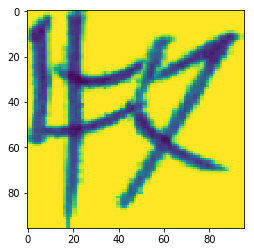

In [22]:
plt.imshow(tg[0][0][1023].reshape((96,96)))

In [24]:
print(len(tg))

219
